In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Yield_Mg_ha":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Yield_Mg_ha,Env
0,13,0.350190,6_2019
1,6,0.064413,9_2018
2,14,0.467534,2_2019
3,7,0.963206,2_2019
4,0,-0.197542,0_2019


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

print(weather_data)

      Env  Year         0         1         2         3         4         5  \
0  0_2019  2019  0.459257  0.737527  0.325568  0.339069  0.319371  0.770840   
1  1_2018  2018  0.709798  0.069978  0.680074  0.400793  0.909106  0.979593   
2  2_2019  2019  0.768011  0.607092  0.777468  0.181033  0.850854  0.803229   
3  3_2018  2018  0.074027  0.409835  0.562800  0.458453  0.520226  0.047150   
4  4_2018  2018  0.878995  0.092641  0.165952  0.608296  0.244000  0.988127   
5  5_2019  2019  0.631363  0.251449  0.969365  0.004020  0.911174  0.923343   
6  6_2019  2019  0.982455  0.177676  0.989299  0.067947  0.768552  0.643219   
7  7_2018  2018  0.331000  0.065025  0.098610  0.933539  0.332291  0.726276   
8  8_2019  2019  0.797633  0.532959  0.616582  0.775982  0.705979  0.317449   
9  9_2018  2018  0.479941  0.077079  0.539941  0.587070  0.406727  0.216224   

          6         7  ...        40        41        42        43        44  \
0  0.145404  0.989743  ...  0.810642  0.210158  0.

In [ ]:
yield_data

,Hybrid,Yield_Mg_ha,Env
0,13,0.350190,6_2019
1,6,0.064413,9_2018
2,14,0.467534,2_2019
3,7,0.963206,2_2019
4,0,-0.197542,0_2019
...,...,...,...
95,18,-0.191020,1_2018
96,10,-0.926472,2_2019
97,3,-0.454691,5_2019
98,10,0.408324,6_2019


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.75302418]])

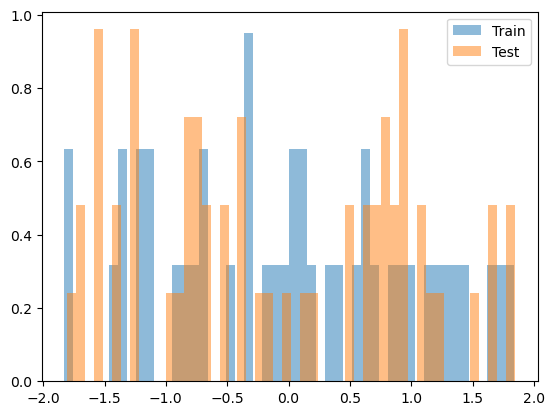

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(tensor(0.1281),
 tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000,
         1.0000, 0.5000]),
 tensor([[ 0.6586, -1.3527,  0.2799,  1.6154, -1.0831, -1.2287,  0.7447,  1.0475,
          -1.7051, -0.6592, -1.6990,  0.8659,  0.1971, -1.5005,  1.4679, -0.0057,
          -1.3124,  0.9911,  0.0959,  1.6687,  0.6416,  1.3909, -0.1510,  1.0113,
           1.3073, -1.7838,  1.4986, -0.6473,  0.9429, -0.3509, -1.2243, -0.0549,
           1.1983, -0.7537, -0.5440,  0.9003,  0.5778, -1.1093, -0.5868,  1.4705,
           1.7104,  0.6460, -1.9530,  0.3982, -0.6292, -0.8740,  1.7787, -0.7473,
          -1.0528, -0.6391]]))

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

In [ ]:
tr_dl = DataLoader(tr_ds, batch_size=4)
te_dl = DataLoader(te_ds, batch_size=4)
dls = DataLoaders(tr_dl,te_dl)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
from torcheval.metrics import MeanSquaredError,Mean, R2Score

In [ ]:
model = MLP(20,100, 1)
cbs = [TrainCB()]
learn = Learner(model, dls, F.mse_loss, lr=.25, cbs=cbs)
learn.fit(1)

/mnt/c/Users/cltng/OneDrive/Documents/Projects/hybridpredictmaize22/hybridpredictmaize22/GEMlearn.py:268: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
